In [280]:
#Load the libraries to be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import math

In [281]:
#Load the data from the downloaded file
tsla_df = pd.read_csv('TSLA.csv')

In [282]:
#Convert the date column to datetime
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'])
#Set the Date column as the index
tsla_df_indexed = tsla_df.set_index('Date')

In [283]:
#Define a function to compute the simple moving average of the historic data
def simple_moving_average(data, window):
    sma = data.rolling(window = window).mean()
    return sma

#Set the number of days for the window
window = 20

#Run the simple_moving_average on the dataframe
tsla_df_indexed['SMA 20'] = simple_moving_average(tsla_df_indexed['Close'], window)

In [284]:
#Define a function to create Bollinger Bands from the data
def create_bands(data, sma, window):
    standard_deviation = data.rolling(window = window).std()
    upper_band = sma + standard_deviation * 2
    lower_band = sma - standard_deviation * 2
    return upper_band, lower_band

tsla_df_indexed['Upper Band'], tsla_df_indexed['Lower Band'] = create_bands(tsla_df_indexed['Close'], tsla_df_indexed['SMA 20'], 20)

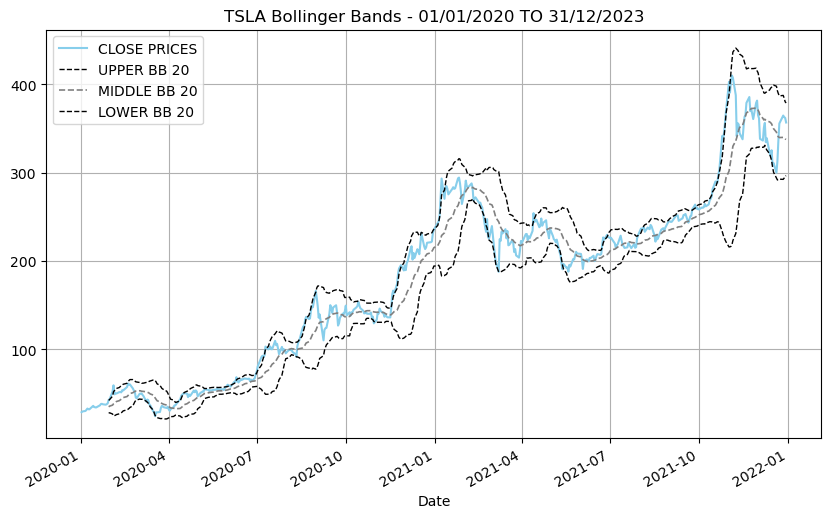

In [285]:
#Plot the figures with the bollinger bands
plt.figure(figsize=(10,6))
plt.title("TSLA Bollinger Bands - 01/01/2020 TO 31/12/2023")
tsla_df_indexed['Close'].plot(label = 'CLOSE PRICES', color = 'skyblue')
tsla_df_indexed['Upper Band'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
tsla_df_indexed['SMA 20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
tsla_df_indexed['Lower Band'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [286]:
#Define a function to generate the trading signals
def implement_bands_strategy(data, lower_band, upper_band):
    buy_price = []
    sell_price = []
    bands_signal = []
    signal = 0
    
    for i in range(len(data)):
        if(data[i-1] > lower_band[i-1] and data[i] < lower_band[i]):
            if(signal != 1):
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        elif(data[i-1] < upper_band[i-1] and data[i] > upper_band[i]):
            if(signal != -1):
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bands_signal.append(0)
            
    return buy_price, sell_price, bands_signal

buy_price, sell_price, bands_signal = implement_bands_strategy(tsla_df_indexed['Close'], tsla_df_indexed['Lower Band'], tsla_df_indexed['Upper Band'])

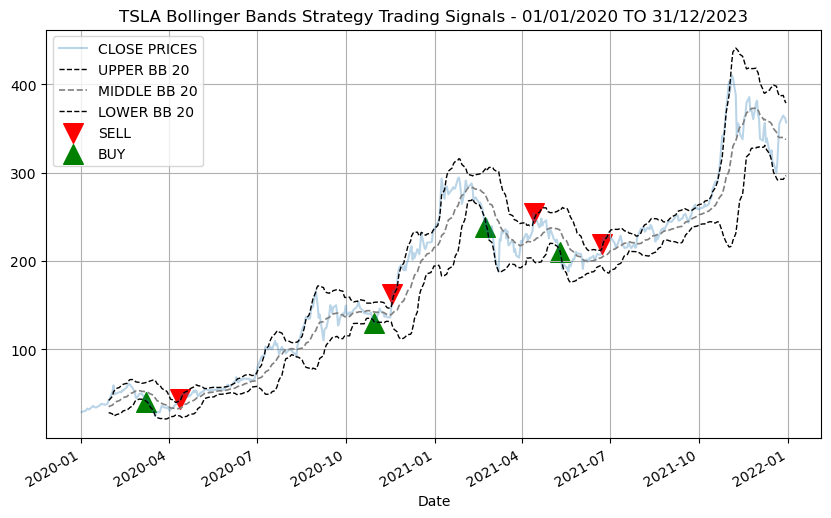

In [287]:
#Plot the figures with the trading signals
plt.figure(figsize = (10,6))
plt.title("TSLA Bollinger Bands Strategy Trading Signals - 01/01/2020 TO 31/12/2023")
tsla_df_indexed['Close'].plot(label = 'CLOSE PRICES', alpha = 0.3)
tsla_df_indexed['Upper Band'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
tsla_df_indexed['SMA 20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
tsla_df_indexed['Lower Band'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(tsla_df_indexed.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.scatter(tsla_df_indexed.index, buy_price, marker='^', color = 'green', label = 'BUY', s = 200)
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [288]:
#Create positions for our strategy
position = []
for i in range(len(bands_signal)):
    if bands_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(tsla_df_indexed['Close'])):
    if bands_signal[i] == 1:
        position[i] = 1
    elif bands_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]

In [289]:
#Add the bands_signal list to the main dataset
tsla_df_indexed.insert(loc = 9,column = 'Band Signals', value = bands_signal)

#Add the positions list to the main dataset
tsla_df_indexed.insert(loc = 10,column = 'Band Position', value = position)

tsla_df_indexed

,Open,High,Low,Close,Adj Close,Volume,SMA 20,Upper Band,Lower Band,Band Signals,Band Position
Date,,,,,,,,,,,
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500,NaN,NaN,NaN,0,1
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,NaN,NaN,NaN,0,1
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000,NaN,NaN,NaN,0,1
2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500,NaN,NaN,NaN,0,1
2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,335.600006,357.660004,332.519989,355.666656,355.666656,92713200,339.725501,386.859807,292.591194,0,0
2021-12-27,357.890015,372.333344,356.906677,364.646667,364.646667,71145900,339.925833,387.466726,292.384940,0,0
2021-12-28,369.829987,373.000000,359.473328,362.823334,362.823334,60324000,339.117166,384.354167,293.880166,0,0


In [290]:
#Calculate the returns for the dataset
tsla_returns = pd.DataFrame(np.diff(tsla_df_indexed['Close'])).rename(columns = {0:'Returns'})
data_strategy = []

for i in range(len(tsla_returns)):
    try:
        returns = tsla_returns['Returns'][i]*strategy['Band Position'][i]
        data_strategy.append(returns)
    except:
        pass

strategy_df = pd.DataFrame(data_strategy).rename(columns = {0:'Strategy'})

In [291]:
#Compute the cummulative returns from the returns dataset
tsla_returns_df['Cummulative Returns'] = tsla_returns['Returns'].cumsum()
tsla_returns_df['Cummulative Strategy'] = strategy_df['Strategy'].cumsum()

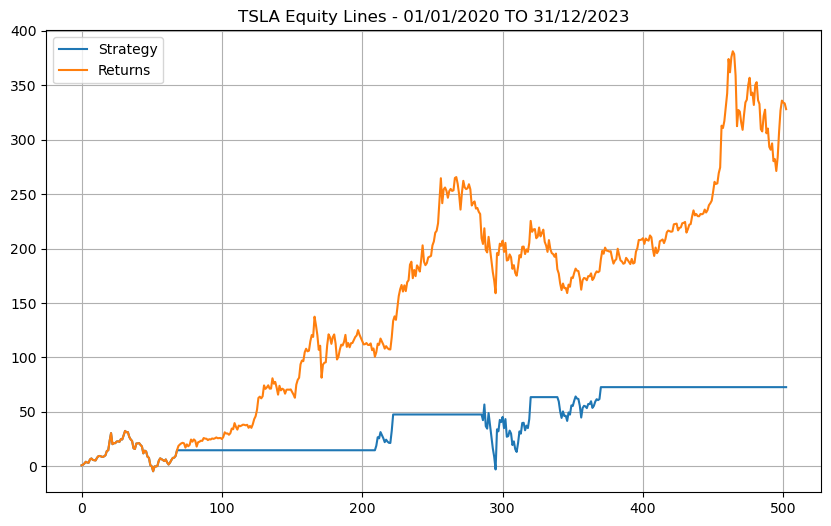

In [292]:
#Plot the figures with the trading signals
plt.figure(figsize = (10,6))
plt.title("TSLA Equity Lines - 01/01/2020 TO 31/12/2023")
plt.plot(tsla_returns_df.index, tsla_returns_df['Cummulative Strategy'], label = "Strategy")
plt.plot(tsla_returns_df.index, tsla_returns_df['Cummulative Returns'], label = "Returns")
plt.legend(loc='upper left')
plt.grid()
plt.show()